In [51]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math, random, copy
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import ipywidgets as widgets

%matplotlib inline

In [2]:
# count the accuracy of our baseline
with open('prediction-child-parents.20170330.txt','r') as preds:
    tp = 0
    tn = 0
    count = 0
    for row in preds:
        myPred = json.loads(row)
        tnode = myPred['target_node']
        for idx in myPred['alpha'].keys():
            alpha = myPred['alpha'][idx]
            if int(idx) != int(tnode):
                if alpha <= 1e-6:
                    tn+=1
                else:
                    tp+=1
                count+=1
                

In [3]:
error_rate = tn / count
accuracy = tp / count
print('Error Rate (False Negative): {}'.format(error_rate))
print('Accuracy (True Positive): {}'.format(accuracy))

Error Rate (False Negative): 0.3458978608794738
Accuracy (True Positive): 0.6541021391205263


In [4]:
# count the accuracy for improved model
import time
with open('prediction-child-parents-p.txt','r') as preds:
    newtp = 0
    newtn = 0
    newcount = 0
    for row in preds:
        myPred = json.loads(row)
        tnode = myPred['target_node']
        for idx in myPred['alpha'].keys():            
            alpha = myPred['alpha'][idx]
            p_value = [ x for x in alpha if x > 1e-6]
            #print(p_value)
            #time.sleep(3)
            if int(idx) != int(tnode):
                if len(alpha)==0 or len(p_value) == 0:
                    newtn+=1
                else:
                    newtp+=1
                newcount+=1

In [5]:
error_rate = newtn / newcount
accuracy = newtp / newcount
print('Error Rate (False Negative): {}'.format(error_rate))
print('Accuracy (True Positive): {}'.format(accuracy))

Error Rate (False Negative): 0.19911323991067673
Accuracy (True Positive): 0.8008867600893232


In [6]:
# TODO
# Provide interactive analysis for choosen observation nodes

In [7]:
# Load all data, nodes, edges, and cascades
# Nodes
nodes = []
nodeHash = {}
with open('nodes.txt','r') as nodesFile:
    for node in nodesFile:
        rownode = node.replace('\n','').split(',')
        nodes.append(rownode[1])
        #nodeHash[rownode[0]] = int(rownode[1])
        nodeHash[int(rownode[1])] = rownode[0]

In [8]:
# Edges
edges = {}
followes = {}
with open('edges.txt','r') as edgesFile:
    for edge in edgesFile:
        edgeJson = edge.replace('\n','').split(',')
        if int(edgeJson[0]) not in edges.keys():
            edges[int(edgeJson[0])] = []
        if int(edgeJson[1]) not in followes.keys():
            followes[int(edgeJson[1])] = []
        edges[int(edgeJson[0])].append(int(edgeJson[1]))
        followes[int(edgeJson[1])].append(int(edgeJson[0]))

In [9]:
def pCoordinate(s2,scale=1):
    # Principal Coordinate analysis,
    # Embedd distance in the 2,3 dimension coordinates
    # Form A matrix
    # test my distance using square and triangle, looks right
    #s2 = [[0,10,14.14,10],[10,0,10,14.14],[14.14,10,0,10],[10,14.14,10,0]]
    #s2 = [[0,10,14.15],[10,0,10],[14.15,10,0]]
    Am = np.identity(s2.shape[0]) - (1/s2.shape[0])*(np.ones(s2.shape[0])*np.ones(s2.shape[0]).T)
    #logger.debug(Am)
    #logger.debug(0.5 * Am * d2 * Am.T)
    # Form W
    Wm = -0.5 * Am * s2 * Am.T
    #logger.debug(Wm)
    # calculate eigen vectors and eigen values of Wm
    evals, evecs = np.linalg.eig(Wm)
    #logger.debug('evals: {}\ndim: {}'.format(evals,evals.shape))
    #logger.debug('evecs: {}\ndim: {}'.format(evecs,evecs.shape))
    # sort by eigenvalue
    indices = np.argsort(evals)
    # turn back the order
    indices = indices[::-1]
    evecs = evecs[:,indices]
    evals = evals[indices]
    Vt = np.sqrt(np.diag(evals[:2])).dot(evecs[:,:2].T)*scale
    result = {}
    #print(Vt)
    for i in range(len(Vt[0,])):
        result[i] = [Vt[0,i],Vt[1,i]]
    return result

In [10]:
# plot accuarcy statistic
baseAcc = pd.read_csv('prediction-child-parents-stat.txt')
improveAcc = pd.read_csv('prediction-child-parents-p-stat.txt')

In [11]:
baseAcc['casMean'] = baseAcc.apply(lambda x: x['TotalCascade']/x['TotalNode'],axis=1)
improveAcc['casMean'] = improveAcc.apply(lambda x: x['TotalCascade']/x['TotalNode'],axis=1)

8.906629127207577

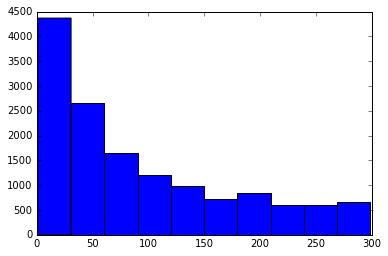

In [12]:
plt.hist(baseAcc[baseAcc.TotalCascade<300].TotalCascade)
baseAcc.groupby('TotalCascade')['TotalCascade'].count()
baseAcc.TotalCascade.mean()
baseAcc.TotalNode.mean()

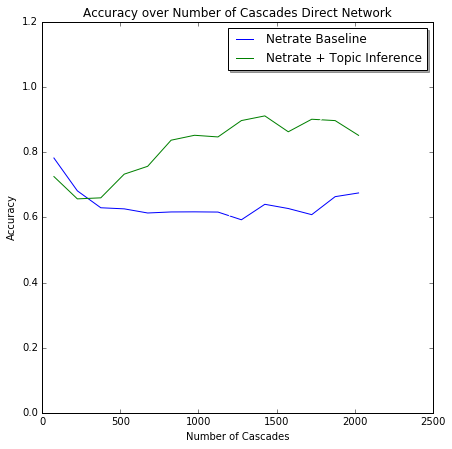

In [13]:
# bin by totalCascade
steplen = 150
maxcas=2000
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = baseAcc[(baseAcc['TotalCascade']>=casSteps[i])&(baseAcc['TotalCascade']<casSteps[i+1])]
    baseCasMean = sampleAcc['Accuracy'].mean()    
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])
    
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = improveAcc[(improveAcc['TotalCascade']>=casSteps[i])&(improveAcc['TotalCascade']<casSteps[i+1])]
    improveCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0:
        improveMeans.append(improveCasMean)
    else:
        improveMeans.append(improveMeans[len(improveMeans)-1])
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

patch_array = []
x1 = plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
x2 = plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate + Topic Inference')

plt.plot([0,maxcas],[0,1.01],color='white',marker='.')
plt.xlabel('Number of Cascades')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Cascades Direct Network')
legend = plt.legend(loc='upper right', shadow=True)

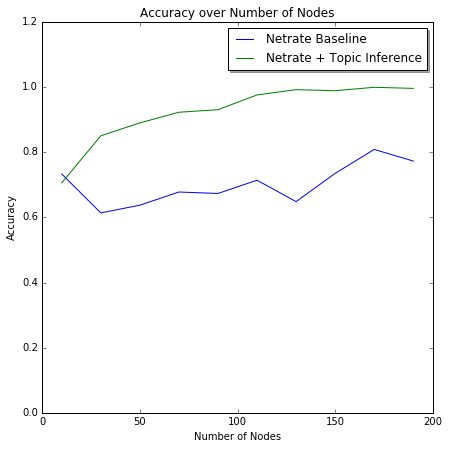

In [14]:
# bin by total Nodes
steplen = 20
maxnode=200
casSteps = np.arange(0,maxnode,steplen)
casSteps = np.append(casSteps,maxnode)
#print(casSteps)

baseMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = baseAcc[(baseAcc['TotalNode']>=casSteps[i])&(baseAcc['TotalNode']<casSteps[i+1])]
    baseCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])
    
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = improveAcc[(improveAcc['TotalNode']>=casSteps[i])&(improveAcc['TotalNode']<casSteps[i+1])]
    improveCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0:
        improveMeans.append(improveCasMean)
    else:
        improveMeans.append(improveMeans[len(improveMeans)-1])

fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate + Topic Inference')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Nodes')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

In [159]:
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpld3 import plugins
import mpld3
from networkx.drawing.nx_agraph import graphviz_layout

def plotOneD(shownode,topic=0,scarcity=1e-5,epsilon=1e-6,scale=1):
    if len(shownode['mat'].shape) > 1:
        show_mat = shownode['mat'][:,topic]
    else:
        show_mat = shownode['mat']
    alpha_mat = show_mat
    alpha_mat = np.where(alpha_mat<0, 0, alpha_mat)
    # normalize distance matrix
    dist_matd = show_mat
    dist_matd = np.where((dist_matd<epsilon) & (dist_matd>0), epsilon, dist_matd)
    dist_matd = np.where((dist_matd<=0), 1e-20, dist_matd)

    dist_mat = np.zeros((show_mat.shape[0],show_mat.shape[0]))
    # make diagonal distance matrix
    transMat = shownode['trans']
    tarMat = shownode['target']

    dist_mat[:,transMat.index(tarMat)] = dist_matd
    for i in range(dist_matd.shape[0]):
        dist_mat[transMat.index(tarMat),i] = dist_matd[i]

    # add small value
    #dist_mat = np.where((dist_mat<=0), 1e-13, dist_mat)

    # add non significant noise to distance matrix for variational rotation
    dist_mat = np.where((dist_mat<=0), np.abs(np.random.normal(0,scarcity)), dist_mat)

    #print(dist_mat)

    for i in range(dist_mat.shape[0]):
        for j in range(i,dist_mat.shape[1]):
            dist_mat[i,j] = (dist_mat[i,j] + dist_mat[j,i]) / 2
            #dist_mat[i,j] = dist_mat[i,j] if dist_mat[i,j] > dist_mat[j,i] else dist_mat[j,i]
            dist_mat[j,i] = dist_mat[i,j]
    #print(dist_mat)        
    max_val = np.max(dist_mat)
    #print(max_val) 
    dist_mat = np.log(max_val/dist_mat)
    #dist_mat = np.where(dist_mat<1e-13, 1e-13, dist_mat)
    for i in range(dist_mat.shape[0]):
        dist_mat[i,i] = 0
    #dist_mat = max_val/np.where(dist_mat<1e-13, 1e-13, dist_mat)
    #dist_mat = np.where(dist_mat<1e-6, 1e-6, dist_mat)
    #print(dist_mat)

    #print(dist_mat)

    #pos = pCoordinate(dist_mat)
    #print(pos)

    #G = nx.from_numpy_matrix(dist_mat) 
    #pos=nx.spring_layout(G,dim=2)
    #pos=graphviz_layout(G,prog='neato')
    #print(pos)

    # measuring distance matrix using principal coordinate analysis
    """
    noise = np.random.normal(0,1e-9,dist_mat.shape[0]*dist_mat.shape[1])
    noise=noise.reshape(dist_mat.shape[0],dist_mat.shape[1])
    test_dist = dist_mat + noise
    pos = pCoordinate(test_dist)
    """
    pos = pCoordinate(dist_mat,scale)

    trans = shownode['trans']
    target_node = trans.index(shownode['target'])
    colors = np.tile('',len(trans))
    parents = []
    neighbors = []
    target = 0
    for i in range(len(trans)):
        tran = trans[i]
        if tran == shownode['target']:
            colors[i]='red'
            target = i
        if tran in shownode['parents']:
            colors[i]='green'
            parents.append(i)
        if tran in shownode['neighbors']:
            colors[i]='blue'
            neighbors.append(i)


    #print(parents)
            
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    #ax = fig.add_subplot(111, projection='3d')

    # draw the lines from parents to target
    """
    for parent in parents:
        linelabel = ax.plot([pos[target][0],pos[parent][0]],[pos[target][1],pos[parent][1]],'-.',c='black',alpha=0.6)
        #print(dist_mat[parent,target])
        #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[parent,target],voffset=10, hoffset=10))
    """

    # draw the lines from the neighbors to all parent
    for neighbor in neighbors:
        act_neighbor = trans[neighbor]
        # get all the parent
        myParents = tedges[act_neighbor]
        for myParent in myParents:
            if myParent in trans:
                pIndex = trans.index(myParent)
                #linelabel = ax.plot([pos[neighbor][0],pos[pIndex][0]],[pos[neighbor][1],pos[pIndex][1]],'-.',c='black',alpha=0.3)
                #print(dist_mat[pIndex,neighbor])
                #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[pIndex,neighbor],voffset=10, hoffset=10))

    for y in range(alpha_mat.shape[0]):
        #print(alpha_mat[y,x])
        if alpha_mat[y] > epsilon:
            linelabel = ax.plot([pos[y][0],pos[target][0]],[pos[y][1],pos[target][1]],'-.',c='black',alpha=0.5)
            #ax.arrow(pos[x][0],pos[x][1],pos[y][0],pos[y][1], head_width=0.05, head_length=0.1, fc='k', ec='k')
                

    patch_array = []
    patch_array.append(mpl.patches.Patch(color='red',label='observation'))
    patch_array.append(mpl.patches.Patch(color='green',label='parent'))
    patch_array.append(mpl.patches.Patch(color='blue',label='neighbor'))
    #leg = ax.legend(handles=patch_array, loc='center left', bbox_to_anchor=(0, 0.5)) 
    leg = ax.legend(handles=patch_array, loc='upper right') 
    # set the alpha value of the legend: it will be translucent
    leg.get_frame().set_alpha(0.3)
                
    labels = []
    x = []
    y = []
    c = []
    for k, p in pos.items():
        #x.append(p[0])
        #y.append(p[1])
        #c.append(colors[k])
        #labels.append(nodeHash[trans[k]])
        scatter = ax.scatter(p[0], p[1], marker='o', c=colors[k], s=50,alpha=0.5, edgecolor='None')
        tooltip = plugins.PointHTMLTooltip(scatter, ['{}, alpha to {}: {}'.format(nodeHash[trans[k]],nodeHash[trans[target_node]],alpha_mat[k])],
                                           voffset=10,hoffset=10)
        plugins.connect(fig, tooltip)
    plt.title('Distance Visualization Target Node: {}'.format(nodeHash[trans[target_node]]))
    

        #ax.scatter(p[0], p[1], p[2], c=colors[k], marker='o')

    #scatter = ax.scatter(x,y, marker='o', c=c, s=50,alpha=0.5, edgecolor='None')


    #lgd = plt.legend(markers, labels, numpoints=1, bbox_to_anchor=(1.17, 0.5))
    #plt.tight_layout()
    #plt.axis('equal')
    #pt.show()
    #print(labels)
    #tooltip = plugins.PointHTMLTooltip(scatter, labels,
    #                                   voffset=10, hoffset=10)
    #plugins.connect(fig, tooltip)

    #mpld3.display()
    mpld3.enable_notebook()


In [121]:
# read the result with probability
predChildParArr = {}
with open('prediction-child-parents.20170331.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        predObj = {}
        target_node = predJson['target_node'] 
        transArr = [target_node]
        alphaArr = []
        parentArr = []
        # recreate alpha matrix
        for key,alpha in predJson['alpha'].items():
            if int(key) not in transArr:
                transArr.append(int(key))
            alphaArr.append(np.array(alpha))
            if int(key) != int(target_node):
                parentArr.append(int(key))
        predChildParArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':[],'mat':np.array(alphaArr)}

In [122]:
# list all the key and website for visualization
idlistnop = list(predChildParArr.keys())
weblistnop = [nodeHash[x] for x in idlistnop]

In [127]:
def shownopplot(web):
    nodeid = weblistnop.index(web[0])
    plotOneD(predChildParArr[idlistnop[nodeid]])

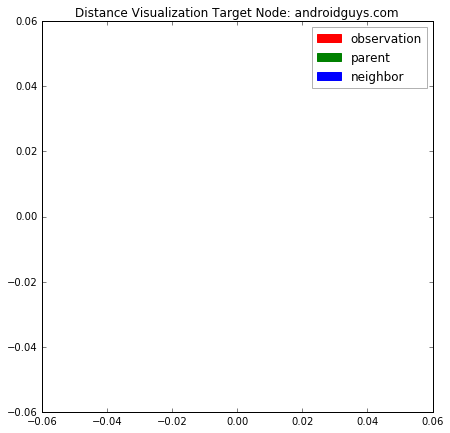

In [161]:
# make ipython widgets
"""
dropdownQuantity = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""        
#webchoose = random.sample(weblistnop,2000)

dropdownQuantity = widgets.SelectMultiple(
            options = webchoose,
            value=[webchoose[0]],
            description='Target Website'
        )

widgets.interact(shownopplot,web=dropdownQuantity)

In [134]:
# read the result with probability
predChildParProbArr = {}
with open('prediction-child-parents-p.20170417.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        predObj = {}
        target_node = predJson['target_node'] 
        transArr = [target_node]
        alphaArr = []
        parentArr = []
        # recreate alpha matrix
        for key,alpha in predJson['alpha'].items():
            if int(key) not in transArr:
                transArr.append(int(key))
            alphaArr.append(np.array(alpha))
            if int(key) != int(target_node):
                parentArr.append(int(key))
        if len(parentArr)>2 :
            predChildParProbArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':[],'mat':np.array(alphaArr)}

In [135]:
# list all the key and website for visualization
idlistwip = list(predChildParProbArr.keys())
weblistwip = [nodeHash[x] for x in idlistwip]

listTopic = ['War','Motivation','Peace','Politic','Opression','Housing','Journal','History','Game','Army','Teamwork','Election','Finance','Danger','Innovation']

def showwipplot(web,topic):
    topic = listTopic.index(topic)
    nodeid = weblistwip.index(web[0])
    #print(predChildParProbArr[idlistwip[nodeid]])
    plotOneD(predChildParProbArr[idlistwip[nodeid]],topic-1)

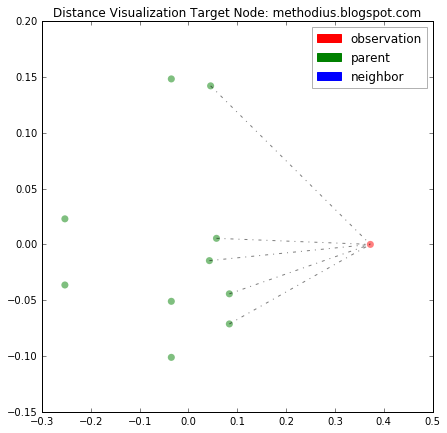

In [162]:
# make ipython widgets
"""
dropdownWebsite = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""
#webchoose = random.sample(weblistwip,3000)
dropdownWebsite = widgets.SelectMultiple(
            options = webchoose,
            value=[webchoose[0]],
            description='Target Website'
        )

dropDownTopic = widgets.Dropdown(
            options = listTopic,
            value= listTopic[0],
            description='Topic'
        )

widgets.interact(showwipplot,web=dropdownWebsite,topic=dropDownTopic)

In [23]:
# Visualization for neighbor
# read the result with probability
predNeighParProbArr = {}
with open('prediction-neighbors-probs.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        target_node = predJson['target_node'] 
        transArr = predJson['trans']
        alphaArr = predJson['alpha']
        parentArr = predJson['parents']
        neighborArr= predJson['neighbors']
        predNeighParProbArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':neighborArr,'mat':np.array(alphaArr)}

In [25]:
tedges = {}
tfollowes = {}
cascade_checker = {}
cascade_count=0
cascades = {}
nodeCascades = {}
with open('cascade-file-parent-probs.txt','r') as casFile:
    for casRead in casFile:
        # prepare cascade
        # load cascade from the file
        obsNode = json.loads(casRead)
        #print(obsNode)
        parent_node = obsNode['node']
        if parent_node not in tfollowes:
            tfollowes[parent_node] = []
        for obsCascades in obsNode['cascades']:
            if obsCascades['url'] not in cascade_checker:
                cascade_checker[obsCascades['url']] = 1
            else:
                continue
            cascade_id = cascade_count
            cascades[cascade_id] = {'probs': obsCascades['probs'],'cas': []}
            for obsCas in obsCascades['cas']:
                dst = int(obsCas['node'])
                if dst not in tfollowes[parent_node]:
                    tfollowes[parent_node].append(dst)
                if dst not in tedges:
                    tedges[dst] = []
                if parent_node not in tedges[dst]:
                    tedges[dst].append(parent_node)
                
                at = float(obsCas['time'])/2505600
                cascades[cascade_id]['cas'].append((at, dst))                

                # append cascadeid to nodes
                if dst not in nodeCascades.keys():
                    nodeCascades[dst] = []
                nodeCascades[dst].append(cascade_id)
            # add new cascade id
            cascade_count+=1

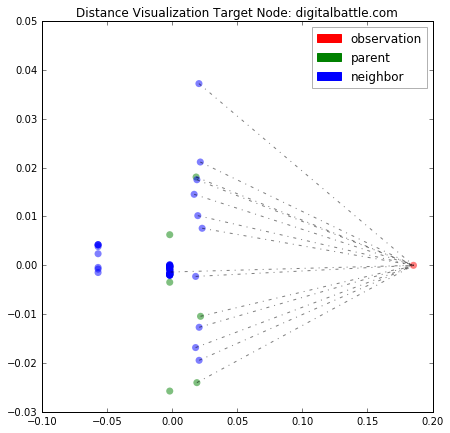

In [168]:
# make ipython widgets
"""
dropdownWebsite = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""
# list all the key and website for visualization
idlistneighwip = list(predNeighParProbArr.keys())
weblistneighwip = [nodeHash[x] for x in idlistneighwip]

listTopic = ['War','Motivation','Peace','Politic','Opression','Housing','Journal','History','Game','Army','Teamwork','Election','Finance','Danger','Innovation']


def showneighwipplot(web,topic):
    topic = listTopic.index(topic)
    nodeid = weblistwip.index(web[0])
    plotOneD(predNeighParProbArr[idlistwip[nodeid]],topic-1,scarcity=1e-3,epsilon=1e-6,scale=2)

dropdownWebsite = widgets.SelectMultiple(
            options = weblistneighwip,
            value=[weblistneighwip[0]],
            description='Target Website'
        )

dropDownTopic = widgets.Dropdown(
            options = listTopic,
            value= listTopic[0],
            description='Topic'
        )

widgets.interact(showneighwipplot,web=dropdownWebsite,topic=dropDownTopic)

In [27]:
neighBase = pd.read_csv('prediction-neighbors-exp-stat.txt')
neighImprove = pd.read_csv('prediction-neighbors-probs-exp-stat.txt')

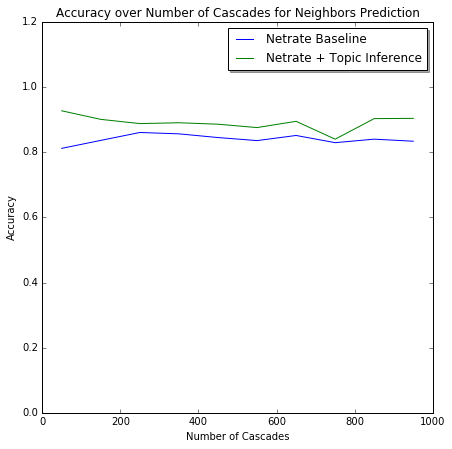

In [30]:
# bin by totalCascade
steplen = 100
maxcas=1000
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = neighBase[(neighBase['TotalCascade']>=casSteps[i])&(neighBase['TotalCascade']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()        
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])

        
for i in range(len(casSteps)-1):
    sampleAcc = neighImprove[(neighImprove['TotalCascade']>=casSteps[i])&(neighImprove['TotalCascade']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()        
    if sampleAcc.shape[0]>0: 
        improveMeans.append(baseCasMean)
    else:
        improveMeans.append(baseMeans[len(baseMeans)-1])
        
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate + Topic Inference')
plt.plot([0,maxnode],[0,1.05],'.',color='white')



plt.xlabel('Number of Cascades')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Cascades for Neighbors Prediction')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

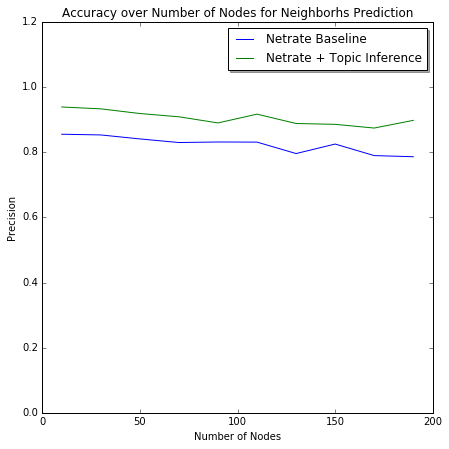

In [31]:
# bin by totalNode
steplen = 20
maxcas=200
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = neighBase[(neighBase['TotalNode']>=casSteps[i])&(neighBase['TotalNode']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TP']+sampleAcc['TN']+sampleAcc.FP+sampleAcc.FN)).mean()    
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])

        
for i in range(len(casSteps)-1):
    sampleAcc = neighImprove[(neighImprove['TotalNode']>=casSteps[i])&(neighImprove['TotalNode']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()    
    if sampleAcc.shape[0]>0: 
        improveMeans.append(baseCasMean)
    else:
        improveMeans.append(baseMeans[len(baseMeans)-1])
        
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate + Topic Inference')
plt.plot([0,maxnode],[0,1.05],'.',color='white')



plt.xlabel('Number of Nodes')
plt.ylabel('Precision')
plt.title('Accuracy over Number of Nodes for Neighborhs Prediction')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

In [32]:
neighbor_net = {}
for key, parents in tedges.items():
    neighborArr = []
    for parent in parents:
        if parent in tfollowes:
            for neighbor in tfollowes[parent]:
                if neighbor in parents:
                    if neighbor not in neighborArr:
                        neighborArr.append(neighbor)
    if len(neighborArr) > 0:
        neighbor_net[key] = neighborArr            

In [33]:
with open('neighbor_net.txt','w') as neighFile:
    neighFile.write(json.dumps(neighbor_net))

In [34]:
neighbor_net

{1: [5231, 9094, 41356],
 32770: [32770],
 32771: [1552,
  2883,
  6250,
  6677,
  7191,
  8099,
  10589,
  20095,
  13864,
  15176,
  15344,
  16497,
  16642,
  23661,
  26347,
  26559,
  28721,
  40479,
  29189,
  29083,
  30041,
  32147,
  42910],
 5: [41083, 42338],
 32769: [12778],
 8: [1655],
 9: [4219, 33011],
 32778: [11636],
 11: [11, 2883, 10894],
 32783: [29289, 33607],
 16: [41529],
 32785: [11293, 15981, 41819],
 3: [3882, 29542, 30456, 34265, 36024, 44176],
 10926: [23847, 43379],
 32790: [17099, 42295],
 32791: [4910],
 25: [41039, 45009],
 32795: [41069],
 32796: [12109],
 29: [3171, 6984],
 32798: [40043, 42710],
 32: [22094, 29794],
 33: [23217, 29852, 41642],
 32802: [35362],
 32803: [6859, 22653, 26137],
 36: [27055],
 38: [43090],
 43697: [43697],
 32808: [26071],
 6548: [2732],
 7: [23958],
 32812: [25811, 30041],
 45: [33946],
 32814: [12115],
 32815: [6344, 15176],
 32776: [7041],
 50: [12472],
 52: [21831],
 32822: [2202,
  24626,
  7113,
  37173,
  7389,
  767

In [36]:
len(neighbor_net)

20265

In [37]:
array_aha = []
for key,test in neighbor_net.items():
    if len(test) > 0:
        array_aha.append(key)

In [38]:
# get sample node list, 10 for each node
nodelist = baseAcc['TotalNode'].unique()
nodelist = np.sort(nodelist)
#sampleArr = []
for totalnode in nodelist:
    total_sample=200
    #targetnodes = baseAcc[baseAcc['TotalNode']==totalnode]['TargetNode']
    targetnodes = baseAcc[baseAcc['TotalNode']==totalnode]
    targetnodes = targetnodes[targetnodes['TargetNode'].isin(array_aha)].TargetNode
    total_sample=total_sample if targetnodes.shape[0] > total_sample else targetnodes.shape[0]
    sample = targetnodes.iloc[random.sample(range(targetnodes.shape[0]),total_sample)].values.tolist()
    if len(sample)>0:
#        print(sample[0])
#        print(neighbor_net[sample[0]])
    #print()
        with open('sample-neighbor-experiment.txt','a') as sampleFile:
            sampleFile.write('{}\n'.format(json.dumps({'totalnode':int(totalnode),'sample':sample})))
    #sampleArr.append(sample)

In [39]:
nodelist[0:100]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  99, 100, 101, 102, 103])

In [40]:
# solve all nodes and get the alpha matrix
import cvxpy as CVX
from collections import defaultdict
import time
import random
import multiprocessing as mp

time_period = 1.0

# Define logSurvival and Hazard function
def logSurvival(t_i, t_j, alpha_ji):
    # survival function for the transmission
    #print('log alpha: {}'.format(alpha_ji))
    return -alpha_ji * (t_i - t_j)

def hazard(t_i, t_j, alpha_ji):
    # hazard function when one node succesfully infected
    #print('haz alpha: {}'.format(alpha_ji))
    #return alpha_ji
    return alpha_ji

def solveParallel(exprArr,Ai,constraints,i,proceed,num_nodes,output):
    #print(exprArr)
    resArray = np.zeros(num_nodes)
    try:
        if proceed:
            #print('expr {}: {}'.format(i,exprArr))
            prob = CVX.Problem(CVX.Maximize(exprArr), constraints)
            res = prob.solve(verbose=False,max_iters=500)
            #print(convexNodes[target_node_loc])
            if prob.status in [CVX.OPTIMAL, CVX.OPTIMAL_INACCURATE]:
                resArray = np.asarray(Ai.value).squeeze()
            else:
                resArray[:] = -1
        else:
            resArray[:] = 0
    except BaseException as e:
        print(e)
        resArray[:] = -1
    output.put((i,resArray))

def solveTargetNodeWithProbM(target_node,k_neighbor = 2):
    # we want to infer transmission rate between child
    # and their parents, whose parent giving faster transmission
    # rate than the others therefore we need to use
    # all the cascades that are pass through the parent edge
    # in our cascade observation

    # reconstruct the nodes id for convex optimization problem
    # we will use our nodes of interest following child and
    # and parent relationship while child is the target node
    convexNodes = {}
    convexNodesArr = []
    convexNodes[target_node] = 0
    convexNodesArr.append(target_node)
    convexNodesCount = 1

    # construct the cascade for following 
    #observationCascadesId = nodeCascades[target_node].copy()
    observationCascadesId = copy.copy(nodeCascades[target_node])

    #print(edges[str(target_node)])

    if target_node not in tedges.keys():
        # target node not in the edges
        return -1

    # prepare neighbor derived from    
    derivedFrom = {}
    # check neighborhood cascade
    neighborArr = []
    for parent in tedges[target_node]:
        convexNodes[parent] = convexNodesCount
        convexNodesArr.append(parent)
        convexNodesCount+=1
        # add 2 random neighbor from the parents
        nFollowers = len(tfollowes[parent])
        k = k_neighbor
        k = k if nFollowers > k else nFollowers
        neighbors = random.sample(range(nFollowers),k)
        for neighbor in neighbors:
            myneighbor = tfollowes[parent][neighbor]
            if myneighbor not in convexNodes:
                convexNodes[myneighbor] = convexNodesCount                
                convexNodesArr.append(myneighbor)
                neighborArr.append(myneighbor)
                if myneighbor in nodeCascades:
                    [observationCascadesId.append(x) for x in nodeCascades[myneighbor]]
                else:
                    print('neighbor {} not found in cascade'.format(myneighbor))
                convexNodesCount+=1
                
                # add neighbor of neighbor if exists
                if myneighbor in tfollowes:
                    n_random = len(tfollowes[myneighbor])
                    k_random = k*2
                    k_random = k_random if n_random > k_random else n_random
                    rand_neighbors = random.sample(tfollowes[myneighbor],k_random)
                    for rand_neighbor in rand_neighbors:
                        if rand_neighbor not in convexNodes:
                            convexNodes[rand_neighbor] = convexNodesCount
                            convexNodesArr.append(rand_neighbor)
                            neighborArr.append(rand_neighbor)
                            if rand_neighbor in nodeCascades:
                                [observationCascadesId.append(x) for x in nodeCascades[rand_neighbor]]
                            convexNodesCount+=1
    
    # reconstruct the observation cascades for this node and their neighbor    
    observationCascades = {}
    for casid in observationCascadesId:
        if casid not in observationCascades:
            observationCascades[casid] = cascades[casid]
            # add neighbor (child) of parent from same cascade
    
    #print(len(observationCascades.keys()))
    #time.sleep(1)

    num_nodes = len(convexNodesArr)

    # prepare the observation matrix
    A = np.zeros((num_nodes, num_nodes, 15), dtype=float)

    for num_node in range(num_nodes):
        # This is one column of the alpha matrix
        #Ai = [CVX.Variable(num_nodes, name='A[:,{}]'.format(convexNodes[target_node])) for i in range(15)]
        Ai = CVX.Variable(num_nodes, name='A[:,{}]'.format(convexNodes[target_node])) 
        constraints=[]
                
        print('{} of {}'.format(num_node+1,num_nodes))
        target_node_loc = convexNodesArr[num_node]
        bad_infection = 0
        expr = 0
        proceed = False        
        
        
        # prepare expression array
        exprArr = [0 for i in range(15)]
        good_infection = np.zeros(num_nodes)            
        
        #for c_idx, c in observationCascades.items():
        #for nodecas in nodeCascades[target_node]:
        #for nodecas in observationCascades:
        for c_idx, citem in observationCascades.items():
            # normalize probability
            cprob = np.array(citem['probs'])
            cprob = cprob/cprob.sum()
            c = citem['cas']
        
            #myCount+=1

            infection_time_arr = [x[0] for x in c if x[1] == target_node_loc]

            assert len(infection_time_arr) <= 1
            
            proceedLog = False

            # computing the survival function of
            # the node i given cascade from j
            # this is unlikely to happen except if we are interested in
            # relation with other cascades on the edges
            if len(infection_time_arr) == 0:
                # Node 'i' was not infected in this cascade

                for j in range(len(c)):
                    # check if the cascade transmission is in our observation nodes or not
                    if c[j][1] in convexNodes.keys():
                        #print('alpha_ji surv: {}'.format(alpha_ji))
                        t_j = c[j][0]
                        T = time_period
                        #print('log sur1: {}'.format(logSurvival(T, t_j, alpha_ji)))
                        alpha_ji = Ai[convexNodes[c[j][1]]]
                        for i in range(len(cprob)):                        
                            #alpha_ji = Ai[i][convexNodes[c[j][1]]]
                            exprArr[i] += logSurvival(T, t_j, alpha_ji)
                            #exprArr[i] += logSurvival(T, t_j, alpha_ji)
                        #print('log expr: {}\n'.format(expr))
                        #proceed=True

                # Instead of making so many parameter for uninteresting
                # cascade better to add counter for bad_infection
                # and multiply it with the survival function
                # in the end. Therefore we can save memory for
                # making a convex function


                # bad_infection+=1
            else:
                # Node 'i' was infected in this cascade
                infection_time = infection_time_arr[0]
                t_i = infection_time

                if c[0][0] != infection_time:
                    # build the logSurvival and hazard function for
                    # the infection
                    # as a result this function will build an expression
                    # that will be solved by convex problem            
                    #log_sum = 0
                    log_sum = [0 for x in range(15)]

                    # check if the infection from the observation nodes
                    # for child and parent relation
                    for j in range(len(c)):
                        if c[j][1] in convexNodes.keys():
                            t_j = c[j][0]
                            #print('alpha_ji haz: {}'.format(alpha_ji))
                            alpha_ji = Ai[convexNodes[c[j][1]]]
                            if t_j < t_i:
                                for i in range(len(cprob)):                                
                                    #alpha_ji = Ai[i][convexNodes[c[j][1]]]
                                    exprArr[i]+=logSurvival(t_i,t_j,alpha_ji)
                                    #exprArr[i]+=logSurvival(t_i,t_j,alpha_ji)
                                    #print('log sur2: {}'.format(logSurvival(t_i,t_j,alpha_ji)))
                                    log_sum[i]+=hazard(t_i,t_j,alpha_ji * cprob[i])
                                    #print('from cas: {}'.format(log_sum[i]))
                                    #time.sleep(3)
                                proceed=True
                                proceedLog=True
                                good_infection[convexNodes[c[j][1]]]+=1                                
                                #pass
                            #print('expr: {}'.format(expr))
                            #time.sleep(1)
                    
                    if proceedLog:
                        for i in range(len(cprob)):
                            #print('from expr: {}'.format(log_sum[i]))
                            exprArr[i] += CVX.log(log_sum[i])
                            #print(exprArr[i])
                            #time.sleep(1)
             
                    #print('expr: {}'.format(expr))
                    #time.sleep(1)

                    # for parent child relation only

        tempA = np.zeros(num_nodes,dtype=float)
        Aarray = np.zeros((num_nodes,len(cprob)))

        # define constraints
        for j in range(num_nodes):
            if good_infection[j]==0:
                constraints.append(Ai[j] == 0)
            else:
                constraints.append(Ai[j] >= 0)
        
        output = mp.Queue()

        argArr = []
        for i in range(15):
            argArr.append((exprArr[i],Ai,constraints,i))

        # Setup a list of processes that we want to run
        processes = [mp.Process(target=solveParallel, args=(x[0], x[1], x[2],x[3],proceed,num_nodes,output)) for x in argArr]

        # Run processes
        for p in processes:
            p.start()

        # Exit the completed processes
        for p in processes:
            p.join()

        # Get process results from the output queue
        results = [output.get() for p in processes]

        results.sort()
        results = [r[1] for r in results]
        Aarray = np.array(results)
        
        """
        for i in range(len(cprob)):
            try:
                if proceed:
                #print(exprArr[i])
                #time.sleep(10)
                    prob = CVX.Problem(CVX.Maximize(exprArr[i]), constraints)
                    res = prob.solve(verbose=False,max_iters=500)
                    #print(convexNodes[target_node_loc])
                    if prob.status in [CVX.OPTIMAL, CVX.OPTIMAL_INACCURATE]:
                        Aarray[:,i] = np.asarray(Ai[i].value).squeeze()
                    else:
                        Aarray[:,i] = -1
                else:
                    Aarray[:,i] = 0
            except BaseException as e:
                print(e)
                Aarray[:,i] = -1
        """
        #print(Aarray)
        A[:,num_node] = Aarray.T
#        print(A[:,num_node])
    return({'mat': A,'target':target_node, 'parents': tedges[target_node],'neighbors': neighborArr,'trans':convexNodesArr})



In [41]:
node1 = solveTargetNodeWithProbM(31141)

1 of 30
2 of 30
3 of 30
Solver 'ECOS' failed. Try another solver.
Solver 'ECOS' failed. Try another solver.
4 of 30
5 of 30
Combined backtracking failed 67 0 23 0 sigma 1
6 of 30
7 of 30
Combined backtracking failed 76 0 14 0 sigma 1
Combined backtracking failed 76 0 14 0 sigma 1
Combined backtracking failed 76 0 14 0 sigma 1
8 of 30
9 of 30
10 of 30
11 of 30
12 of 30
13 of 30
14 of 30
15 of 30
16 of 30
17 of 30
18 of 30
19 of 30
20 of 30
21 of 30
22 of 30
23 of 30
24 of 30
Solver 'ECOS' failed. Try another solver.
Combined backtracking failed 78 0 12 0 sigma 1
Solver 'ECOS' failed. Try another solver.
25 of 30
26 of 30
27 of 30
28 of 30
29 of 30
30 of 30


In [146]:
node2 = solveTargetNodeWithProbM(19411)

1 of 69
Combined backtracking failed 90 0 0 0 sigma 1
Combined backtracking failed 90 0 0 0 sigma 1
2 of 69
3 of 69
4 of 69
5 of 69
6 of 69
Combined backtracking failed 84 0 6 0 sigma 1
Solver 'ECOS' failed. Try another solver.
7 of 69
8 of 69
Combined backtracking failed 65 0 25 0 sigma 1
Solver 'ECOS' failed. Try another solver.
Solver 'ECOS' failed. Try another solver.
Solver 'ECOS' failed. Try another solver.
9 of 69
Solver 'ECOS' failed. Try another solver.
10 of 69
11 of 69
12 of 69
13 of 69
14 of 69
15 of 69
16 of 69
17 of 69
18 of 69
Combined backtracking failed 71 0 19 0 sigma 1
19 of 69
Combined backtracking failed 73 0 17 0 sigma 1
Solver 'ECOS' failed. Try another solver.
20 of 69
21 of 69
22 of 69
23 of 69
24 of 69
Combined backtracking failed 88 0 2 0 sigma 1
25 of 69
Combined backtracking failed 0 0 90 0 sigma 1
26 of 69
27 of 69
Combined backtracking failed 63 0 27 0 sigma 1
28 of 69
29 of 69
30 of 69
31 of 69
32 of 69
33 of 69
34 of 69
Combined backtracking failed 86 3

In [147]:
node3 = solveTargetNodeWithProbM(11285)

1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
Solver 'ECOS' failed. Try another solver.
Solver 'ECOS' failed. Try another solver.
6 of 19
7 of 19
Combined backtracking failed 0 0 90 0 sigma 1
Combined backtracking failed 14 0 76 0 sigma 1
Combined backtracking failed 13 0 77 0 sigma 1
8 of 19
9 of 19
10 of 19
11 of 19
Combined backtracking failed 85 0 5 0 sigma 1
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19
19 of 19


In [166]:
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpld3 import plugins
import mpld3
from networkx.drawing.nx_agraph import graphviz_layout

def showSample(node1,topic=0):
    epsilon = 1e-6

    shownode = node1
    show_mat = shownode['mat'][:,:,topic]
    alpha_mat = show_mat
    alpha_mat = np.where(alpha_mat<0, 0, alpha_mat)
    # normalize distance matrix
    dist_mat = show_mat
    dist_mat = np.where((dist_mat<epsilon) & (dist_mat>0), epsilon, dist_mat)
    dist_mat = np.where((dist_mat<=0), 1e-9, dist_mat)
    # make diagonal distance matrix
    for i in range(dist_mat.shape[0]):
        for j in range(i,dist_mat.shape[1]):
            dist_mat[i,j] = (dist_mat[i,j] + dist_mat[j,i]) / 2
            #dist_mat[i,j] = dist_mat[i,j] if dist_mat[i,j] > dist_mat[j,i] else dist_mat[j,i]
            dist_mat[j,i] = dist_mat[i,j]
    #print(dist_mat)        
    max_val = np.max(dist_mat)
    #print(max_val) 
    dist_mat = np.log(max_val/dist_mat)
    #dist_mat = np.where(dist_mat<1e-13, 1e-13, dist_mat)
    for i in range(dist_mat.shape[0]):
        dist_mat[i,i] = 0
    #dist_mat = max_val/np.where(dist_mat<1e-13, 1e-13, dist_mat)
    #dist_mat = np.where(dist_mat<1e-6, 1e-6, dist_mat)
    #print(dist_mat)


    #pos = pCoordinate(dist_mat)
    #print(pos)

    #G = nx.from_numpy_matrix(dist_mat) 
    #pos=nx.spring_layout(G,dim=2,k=0.3)
    #pos=graphviz_layout(G,prog='neato')
    #print(pos)

    # measuring distance matrix using principal coordinate analysis
    noise = np.random.normal(0,1e-5,dist_mat.shape[0]*dist_mat.shape[1])
    noise=noise.reshape(dist_mat.shape[0],dist_mat.shape[1])
    test_dist = dist_mat + noise
    pos = pCoordinate(test_dist)

    trans = shownode['trans']
    target_node = trans.index(shownode['target'])
    colors = np.tile('',len(trans))
    parents = []
    neighbors = []
    target = 0
    for i in range(len(trans)):
        tran = trans[i]
        if tran == shownode['target']:
            colors[i]='red'
            target = i
        if tran in shownode['parents']:
            colors[i]='green'
            parents.append(i)
        if tran in shownode['neighbors']:
            colors[i]='blue'
            neighbors.append(i)


    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    #ax = fig.add_subplot(111, projection='3d')

    # draw the lines from parents to target
    """
    for parent in parents:
        linelabel = ax.plot([pos[target][0],pos[parent][0]],[pos[target][1],pos[parent][1]],'--',c='black',alpha=0.3)
        #print(dist_mat[parent,target])
        #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[parent,target],voffset=10, hoffset=10))
    """

    # draw the lines from the neighbors to all parent
    for neighbor in neighbors:
        act_neighbor = trans[neighbor]
        # get all the parent
        myParents = tedges[act_neighbor]
        for myParent in myParents:
            if myParent in trans:
                pIndex = trans.index(myParent)
                """
                linelabel = ax.plot([pos[neighbor][0],pos[pIndex][0]],[pos[neighbor][1],pos[pIndex][1]],'--',c='black',alpha=0.3)
                """
                #print(dist_mat[pIndex,neighbor])
                #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[pIndex,neighbor],voffset=10, hoffset=10))

    for y in range(alpha_mat.shape[0]):
        for x in range(alpha_mat.shape[0]):
            #print(alpha_mat[y,x])
            if alpha_mat[y,x] > epsilon:
                linelabel = ax.plot([pos[y][0],pos[x][0]],[pos[y][1],pos[x][1]],'-.',c='black',alpha=0.5)
                #ax.arrow(pos[x][0],pos[x][1],pos[y][0],pos[y][1], head_width=0.05, head_length=0.1, fc='k', ec='k')
                plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],'{} to {}: {}'.format(nodeHash[trans[y]],nodeHash[trans[x]],alpha_mat[y,x]),voffset=10, hoffset=10))                


    labels = []
    x = []
    y = []
    c = []
    for k, p in pos.items():
        #x.append(p[0])
        #y.append(p[1])
        #c.append(colors[k])
        #labels.append(nodeHash[trans[k]])
        scatter = ax.scatter(p[0], p[1], marker='o', c=colors[k], s=50,alpha=0.5, edgecolor='None')
        #tooltip = plugins.PointHTMLTooltip(scatter, ['{}, alpha to {}: {}'.format(nodeHash[trans[k]],nodeHash[trans[target_node]],alpha_mat[k,target_node])],
        #                                   voffset=10,hoffset=10)
        #plugins.connect(fig, tooltip)


        #ax.scatter(p[0], p[1], p[2], c=colors[k], marker='o')

    #scatter = ax.scatter(x,y, marker='o', c=c, s=50,alpha=0.5, edgecolor='None')


    #lgd = plt.legend(markers, labels, numpoints=1, bbox_to_anchor=(1.17, 0.5))
    #plt.tight_layout()
    #plt.axis('equal')
    #pt.show()
    #print(labels)
    #tooltip = plugins.PointHTMLTooltip(scatter, labels,
    #                                   voffset=10, hoffset=10)
    #plugins.connect(fig, tooltip)

    #mpld3.display()
    mpld3.enable_notebook()

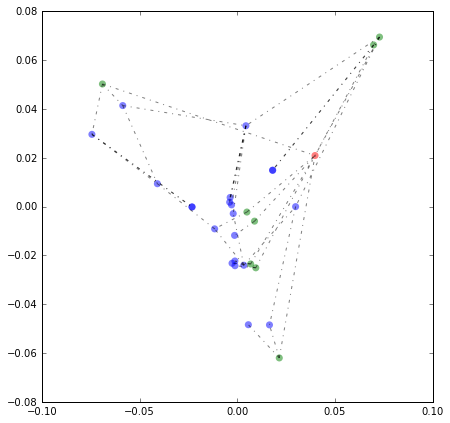

In [169]:
# make ipython widgets
# list all the key and website for visualization
listTopic = ['War','Motivation','Peace','Politic','Opression','Housing','Journal','History','Game','Army','Teamwork','Election','Finance','Danger','Innovation']
listexample = [node1,node2,node3]

def showSamplePlot(exindex,topic):
    topic = listTopic.index(topic)
    showSample(listexample[int(exindex)],topic)

dropDownExample = widgets.Dropdown(
            options = ['0','1','2'],
            value= '0',
            description='Example'
        )    
dropDownTopic = widgets.Dropdown(
            options = listTopic,
            value= listTopic[0],
            description='Topic'
        )

widgets.interact(showSamplePlot,exindex=dropDownExample,topic=dropDownTopic)